# Análisis Exploratorio de Datos (EDA)

Este notebook realiza un análisis exploratorio completo de nuestro conjunto de datos. Examinaremos las características básicas del dataset, la distribución de la variable objetivo, las relaciones entre variables numéricas y categóricas, y realizaremos visualizaciones para mejor comprensión de los datos.

## 1. Importación de Librerías

Comenzamos importando las bibliotecas necesarias para nuestro análisis. Utilizaremos pandas para manipulación de datos, numpy para operaciones numéricas, y matplotlib junto con seaborn para visualizaciones.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Configuración para visualizaciones más atractivas
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

## Añadiendo Settings Paths

In [5]:
import os
# Setting paths
current_dir = os.getcwd()                   # archivo eda.ipynb
parent_dir = os.path.dirname(current_dir)   # carpeta notebooks
data_dir = os.path.join(parent_dir, "data") # carpeta data
file_path = os.path.join(data_dir, "")      # algo demto de la carpeta data

raw_data_csv_path = os.path.join(data_dir, "for_trying_model.csv")  # El archivo crudo a leer

## 2. Carga y Análisis Básico de Datos

En esta sección, cargaremos nuestro dataset y realizaremos un análisis básico para entender su estructura, dimensiones y características generales. Examinaremos la presencia de valores nulos y obtendremos estadísticas descriptivas básicas.

In [6]:
# Cargar los datos
df = pd.read_csv(raw_data_csv_path)

def analisis_basico(df):
    print("Dimensiones del dataset:", df.shape)
    print("Información del dataset:")
    print(df.info())
    print("Estadísticas descriptivas:")
    print(df.describe())
    print("Valores nulos por columna:")
    print(df.isnull().sum())

analisis_basico(df)

Dimensiones del dataset: (4424, 35)
Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   marital_status                                  4424 non-null   object 
 1   application_mode                                4424 non-null   object 
 2   application_order                               4424 non-null   int64  
 3   course                                          4424 non-null   object 
 4   attendance                                      4424 non-null   object 
 5   previous_qualification                          4424 non-null   object 
 6   nationality                                     4424 non-null   object 
 7   mother's_qualification                          4424 non-null   object 
 8   father's_qualification                          4424 non-

## 3. Limpieza de Datos
En esta sección realizamos la limpieza inicial de los datos, tratando valores nulos y anomalías

In [7]:
def limpiar_datos(df):
    # Crear una copia para no modificar los datos originales
    df_clean = df.copy()
    
    # Identificar columnas numéricas y categóricas
    columnas_numericas = df_clean.select_dtypes(include=['float64', 'int64']).columns
    columnas_categoricas = df_clean.select_dtypes(include=['object']).columns
    
    # Tratar valores nulos en columnas numéricas
    imputer_num = SimpleImputer(strategy='median')
    df_clean[columnas_numericas] = imputer_num.fit_transform(df_clean[columnas_numericas])
    
    # Tratar valores nulos en columnas categóricas
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df_clean[columnas_categoricas] = imputer_cat.fit_transform(df_clean[columnas_categoricas])
    
    return df_clean

# Aplicar limpieza
df_limpio = limpiar_datos(df)

# Verificar que no hay valores nulos
print("Valores nulos después de la limpieza:")
display(df_limpio.isnull().sum())

Valores nulos después de la limpieza:


marital_status                                    0
application_mode                                  0
application_order                                 0
course                                            0
attendance                                        0
previous_qualification                            0
nationality                                       0
mother's_qualification                            0
father's_qualification                            0
mother's_occupation                               0
father's_occupation                               0
displaced                                         0
educational_special_needs                         0
debtor                                            0
tuition_fees_up_to_date                           0
gender                                            0
scholarship_holder                                0
age_at_enrollment                                 0
international                                     0
curricular_u

## 4. Preprocesamiento de Datos
Aquí realizamos las transformaciones necesarias para preparar los datos para el análisis.

In [8]:
def preprocesar_datos(df):
    """
    Realiza el preprocesamiento con codificación binaria para variables categóricas
    y mantiene el target como 0, 1, 2
    """
    df_proc = df.copy()
    
    # Primero codificamos el target de manera simple (0, 1, 2)
    target_mapping = {
        'Dropout': 0,
        'Graduate': 1,
        'Enrolled': 2
    }
    df_proc['Target'] = df_proc['Target'].map(target_mapping)
    
    # Convertir variables categóricas a binarias (one-hot encoding)
    categoricas = df_proc.select_dtypes(include=['object']).columns
    
    # Aplicar one-hot encoding a todas las variables categóricas
    df_proc = pd.get_dummies(df_proc, columns=categoricas, drop_first=True)
    
    # Normalizar variables numéricas
    scaler = StandardScaler()
    numericas = df_proc.select_dtypes(include=['float64', 'int64']).columns
    numericas = numericas.drop('Target') if 'Target' in numericas else numericas
    df_proc[numericas] = scaler.fit_transform(df_proc[numericas])
    
    # Verificar la codificación del target
    print("\nCodificación del Target:")
    print("0: Dropout (Abandono)")
    print("1: Graduate (Graduado)")
    print("2: Enrolled (Matriculado)")
    
    # Mostrar distribución de clases
    print("\nDistribución de clases después del preprocesamiento:")
    print(df_proc['Target'].value_counts().sort_index().to_frame().join(
        df_proc['Target'].value_counts(normalize=True).sort_index().mul(100).round(2).astype(str).add('%').to_frame(
            name='Porcentaje'
        )
    ))
    
    # Mostrar las nuevas características binarias creadas
    print("\nNuevas características binarias creadas:")
    columnas_binarias = [col for col in df_proc.columns if col not in numericas and col != 'Target']
    print(columnas_binarias)
    
    return df_proc

# Aplicar limpieza y preprocesamiento
df_limpio = limpiar_datos(df)
df_procesado = preprocesar_datos(df_limpio)

# Guardar dataset procesado
df_procesado.to_csv('../data/processed/dataset_procesado.csv', index=False)
print("\nDataset procesado guardado exitosamente")

KeyError: 'Target'

## 5. Análisis de la Variable Objetivo

Analizaremos la distribución de nuestra variable objetivo (Target). Es crucial entender si las clases están balanceadas o si existe un desequilibrio que debamos considerar en nuestro modelo.

In [9]:
def analisis_target(df):
    plt.figure(figsize=(10, 6))
    target_counts = df['Target'].value_counts()
    sns.barplot(x=target_counts.index, y=target_counts.values)
    plt.title('Distribución de la Variable Objetivo')
    plt.xlabel('Clase')
    plt.ylabel('Cantidad')
    plt.show()

analisis_target(df)

# Mostrar porcentajes de cada clase
print("Porcentaje de cada clase:")
print(df['Target'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

KeyError: 'Target'

<Figure size 1000x600 with 0 Axes>

## 6. Análisis de Variables Numéricas

Examinaremos la distribución de nuestras variables numéricas mediante histogramas y analizaremos las correlaciones entre ellas. Esto nos ayudará a identificar patrones y relaciones importantes en los datos.

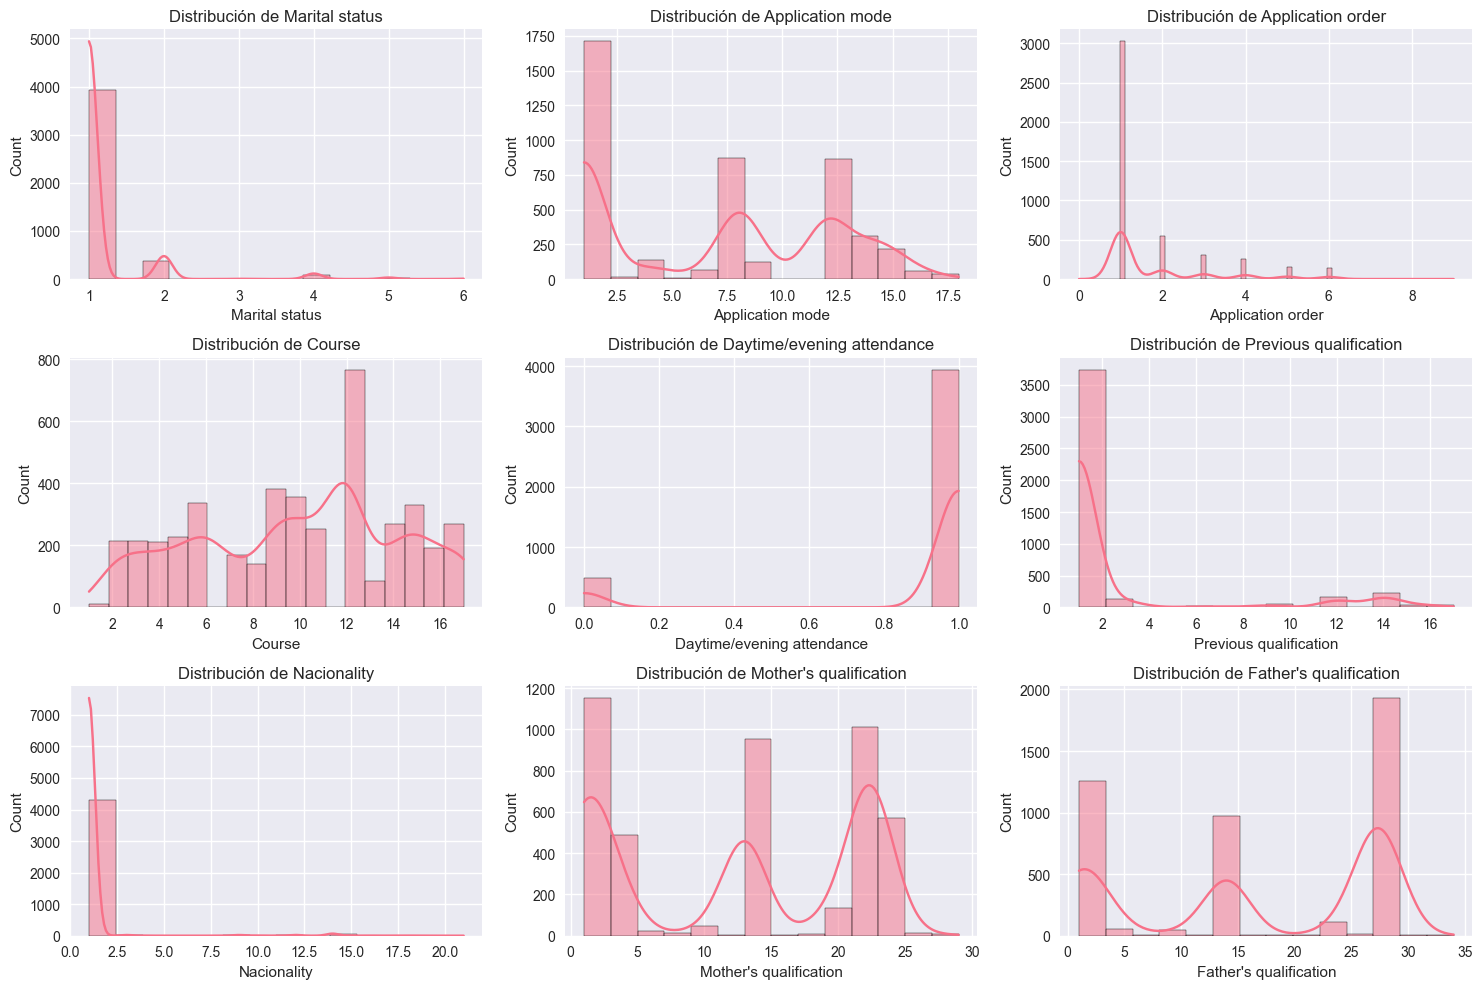

In [ ]:
def analisis_numericas(df):
    numericas = df.select_dtypes(include=['float64', 'int64']).columns
    
    # Histogramas
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numericas[:9], 1):
        plt.subplot(3, 3, i)
        sns.histplot(data=df, x=col, kde=True)
        plt.title(f'Distribución de {col}')
    plt.tight_layout()
    plt.show()

analisis_numericas(df)

## 7. Análisis de Variables Categóricas

Para las variables categóricas, analizaremos su distribución y frecuencia. Esto nos ayudará a identificar categorías dominantes y posibles valores atípicos.

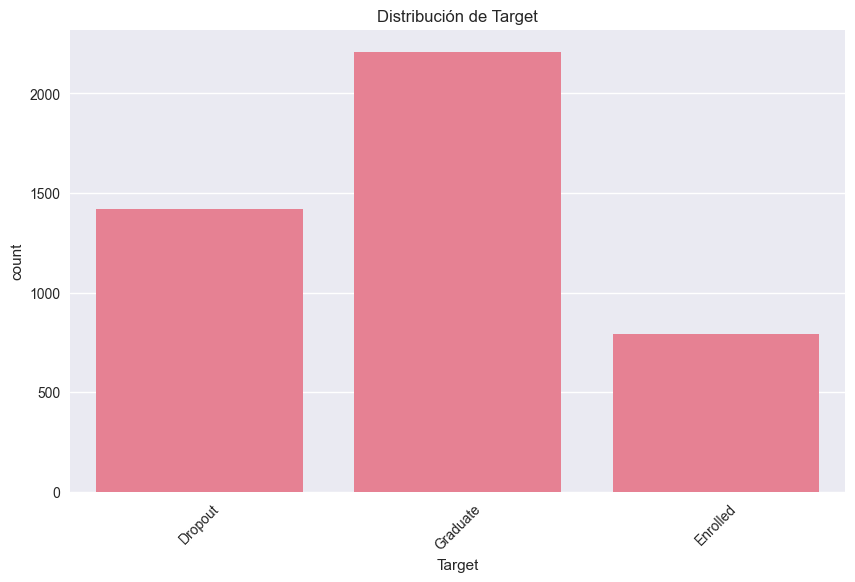

Distribución de Target:
          count Porcentaje
Target                    
Graduate   2209     49.93%
Dropout    1421     32.12%
Enrolled    794     17.95%


In [ ]:
def analisis_categoricas(df):
    categoricas = df.select_dtypes(include=['object']).columns
    
    for col in categoricas:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=col)
        plt.title(f'Distribución de {col}')
        plt.xticks(rotation=45)
        plt.show()
        
        # Mostrar frecuencias y porcentajes
        print(f"Distribución de {col}:")
        print(df[col].value_counts().to_frame().join(
            df[col].value_counts(normalize=True).mul(100).round(2).astype(str).add('%').to_frame(
                name='Porcentaje'
            )
        ))

analisis_categoricas(df)

## 8. Análisis Bivariado con Target

Finalmente, analizaremos la relación entre nuestras variables numéricas y la variable objetivo mediante box plots. Esto nos ayudará a identificar qué variables podrían ser más importantes para la clasificación.

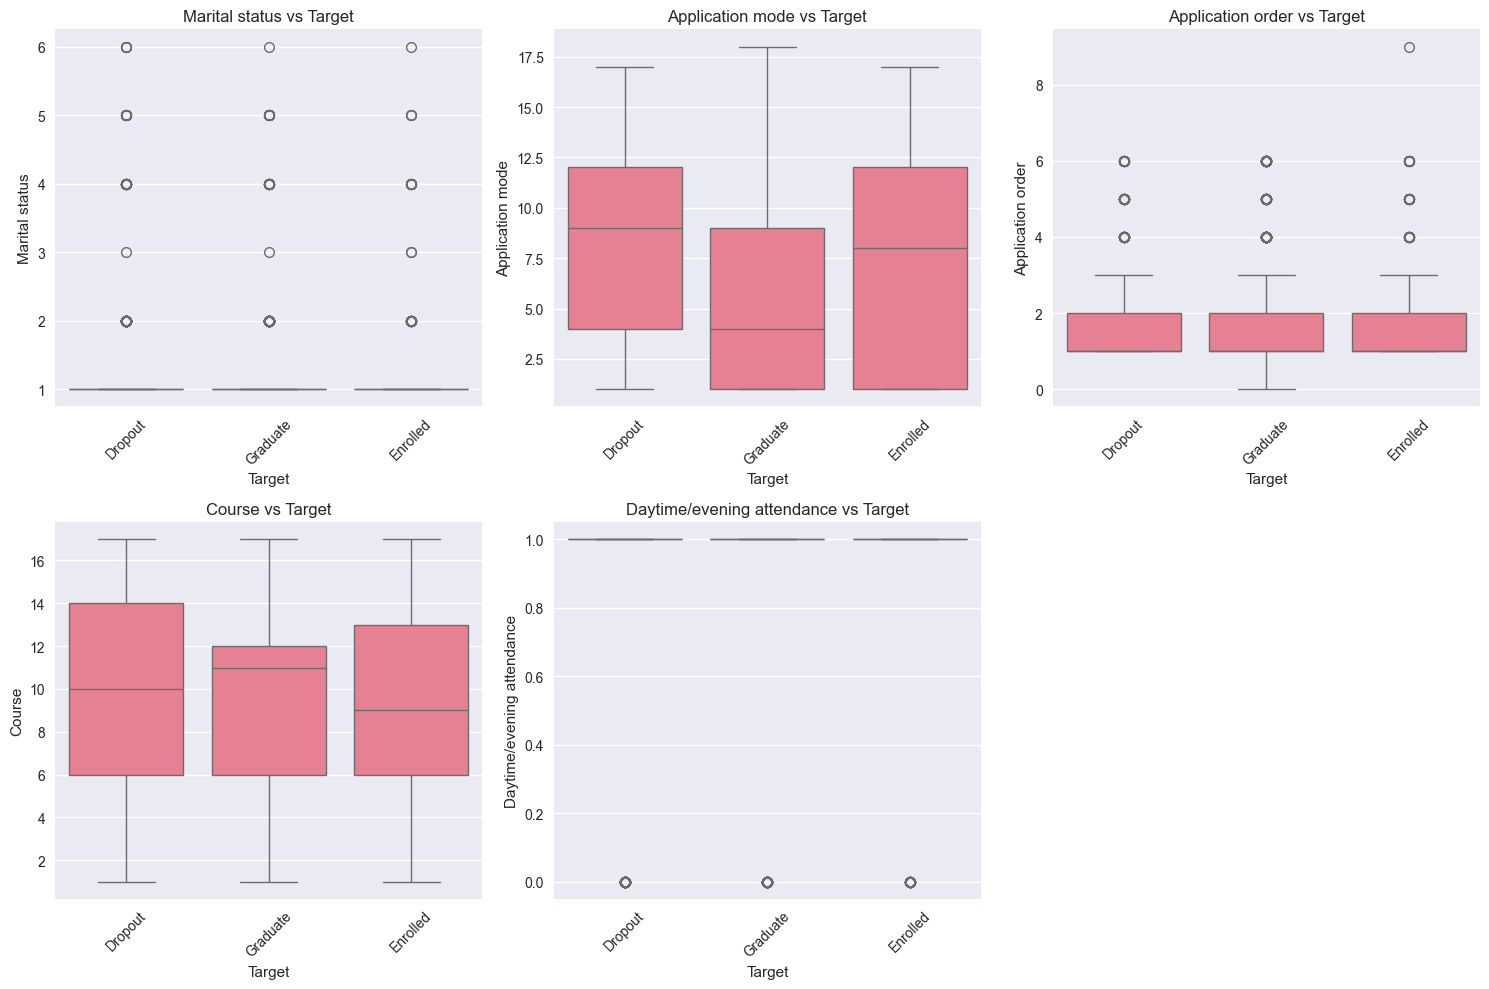

In [ ]:
def analisis_bivariado(df):
    numericas = df.select_dtypes(include=['float64', 'int64']).columns[:5]
    
    # Box plots para variables numéricas vs Target
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numericas, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(data=df, x='Target', y=col)
        plt.title(f'{col} vs Target')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

analisis_bivariado(df)

## 9. Análisis de Correlaciones
Finalmente, analizamos las correlaciones entre variables numéricas.

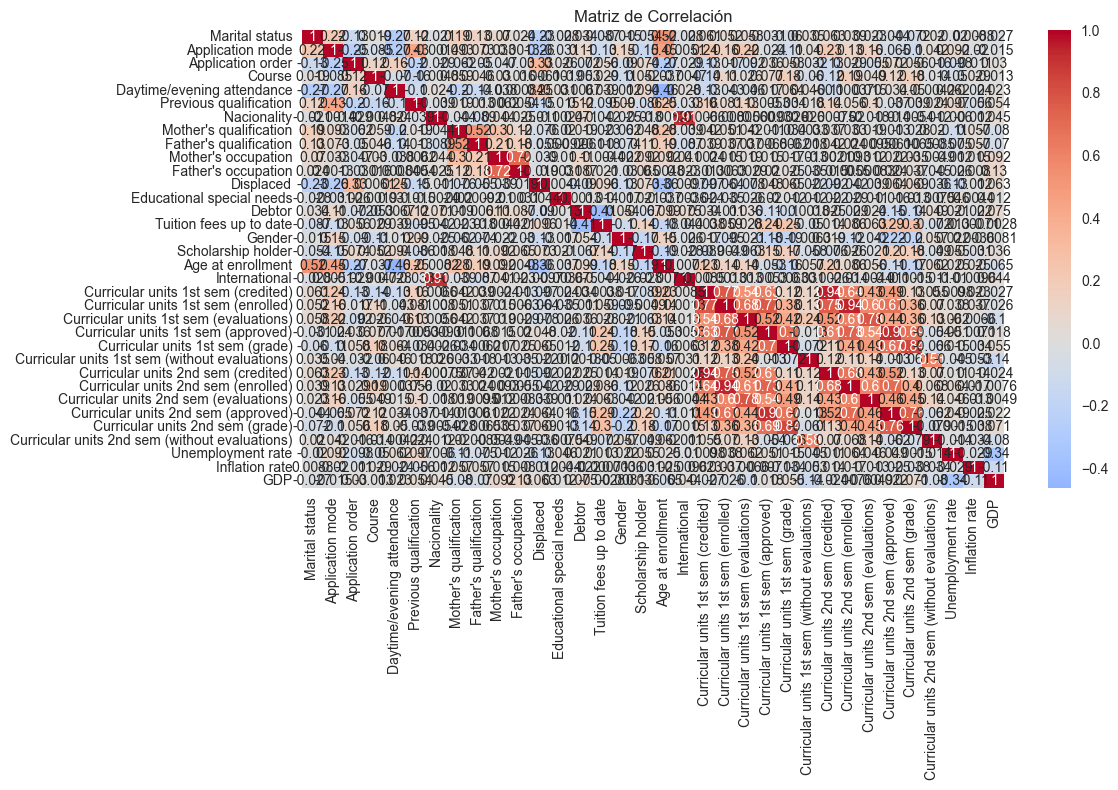

In [ ]:
# Crear matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(df_limpio.select_dtypes(include=['float64', 'int64']).corr(), 
            annot=True, 
            cmap='coolwarm', 
            center=0)
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

## 10. Variables Seleccionadas para Modelado
### Variables Numéricas:
- Curricular units 1st sem (grade)
- Curricular units 2nd sem (grade)
- Curricular units 1st sem (approved)
- Curricular units 2nd sem (approved)
- Age at enrollment
- GDP
- Unemployment rate
### Variables Categóricas (One-Hot Encoded):
- Previous qualification
- Scholarship holder
- Displaced
- Educational special needs
- Course
- Daytime/evening attendance
- Tuition fees up to date
## 11. Conclusiones del EDA
1. Distribución de Clases :
   
   - Existe un desbalance moderado entre las clases
   - Se recomienda considerar técnicas de balanceo
2. Correlaciones Importantes :
   
   - Alta correlación entre notas de diferentes semestres
   - Relación significativa entre unidades aprobadas y calificaciones
3. Variables Predictivas Clave :
   
   - Las calificaciones son los mejores predictores
   - Factores socioeconómicos muestran influencia moderada
   - Variables categóricas aportan información valiosa sobre el perfil del estudiante
4. Recomendaciones para Modelado :
   
   - Usar técnicas de balanceo de clases
   - Considerar interacciones entre variables académicas
   - Mantener todas las variables seleccionadas
   - Evaluar modelos con validación cruzada